In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns; sns.set()
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, auc

In [2]:
testfile = 'Bladder Project pCR Prediction Data (Updated 030222).txt'
df=pd.read_csv(testfile,sep='\t', index_col=0)
display(df)

,pCR,Age,Sex,Race,Urothelial,Smoking,NAC,MIBC,Incidental PC,utDNA,TF99
ID,,,,,,,,,,,
WBC1045,0,63,1,1,1,1,1,1,1,2.4,2.400
WBC1050,1,63,2,1,1,1,1,1,0,0.0,2.500
WBC1058,0,78,1,1,1,0,0,1,0,5.9,2.400
WBC1062,0,77,1,1,0,1,1,1,0,2.4,1.600
WBC1063,1,67,1,1,1,0,1,1,0,0.0,1.700
...,...,...,...,...,...,...,...,...,...,...,...
WBC1312,1,61,1,1,1,0,1,0,0,0.0,0.000
WBC1313,0,48,1,1,0,0,1,1,0,1.9,18.300
WBC1314,1,73,2,1,1,1,1,1,0,0.3,0.000


In [3]:
# Perform operation on utDNA and TF99 and drop the unwanted columns
testratio=32/74
df_test = df.copy()
df_test['Sum'] = np.power((np.array(df['utDNA']) + 1) * (np.array(df['TF99']) + 1), 1.5)
df_test = df_test[['pCR', 'Age', 'Sex', 'Race', 'Urothelial', 'Smoking', 'NAC', 'MIBC', 'Sum','Incidental PC']]
display(df_test)

,pCR,Age,Sex,Race,Urothelial,Smoking,NAC,MIBC,Sum,Incidental PC
ID,,,,,,,,,,
WBC1045,0,63,1,1,1,1,1,1,39.304000,1
WBC1050,1,63,2,1,1,1,1,1,6.547900,0
WBC1058,0,78,1,1,1,0,0,1,113.629740,0
WBC1062,0,77,1,1,0,1,1,1,26.283210,0
WBC1063,1,67,1,1,1,0,1,1,4.436553,0
...,...,...,...,...,...,...,...,...,...,...
WBC1312,1,61,1,1,1,0,1,0,1.000000,0
WBC1313,0,48,1,1,0,0,1,1,418.728923,0
WBC1314,1,73,2,1,1,1,1,1,1.482228,0


In [4]:
# Perform machine learning
X=df_test.drop(['pCR'],axis=1)
Y=df_test["pCR"].copy()
ind = df_test.index
trainX,testX,trainY,testY,train_in,test_in =  train_test_split(X,Y,ind,test_size=testratio, random_state=0)
my_final_classifier = RandomForestClassifier(n_estimators=20000, oob_score=True,random_state=0)
#my_final_classifier = RandomForestClassifier(n_estimators=2000, oob_score=True,random_state=0)
my_final_classifier.fit(trainX, trainY)

# Get the probability predictions 
pred = my_final_classifier.predict_proba(testX)[:,1]
pred_train = my_final_classifier.predict_proba(trainX)[:,1]
pred_all = my_final_classifier.predict_proba(trainX.append(testX))[:,1]

print('Oob_score =', my_final_classifier.oob_score_)
print('ROC Score =', roc_auc_score(testY, my_final_classifier.predict_proba(testX)[:,1]))

# Get the sensitivity and specificity for each set of data
fpr_train, tpr_train, thresholds_train = roc_curve(trainY, pred_train)
sens_train = tpr_train
spec_train = 1 - fpr_train
gmeans_train = np.sqrt(sens_train * spec_train)
ix_train = np.argmax(gmeans_train)
fpr, tpr, thresholds = roc_curve(testY, pred)
sens_pred = tpr
spec_pred = 1 - fpr
gmeans = np.sqrt(tpr * (1-fpr))
thresh = thresholds[ix_train]
print('Best Threshold=%f, G-Mean=%.3f' % (thresh, gmeans_train[ix_train]), '\n')
fpr_all, tpr_all, thresholds_all = roc_curve(trainY.append(testY), pred_all)
sens_all = tpr_all
spec_all = 1 - fpr_all
gmeans_all = np.sqrt(sens_all * spec_all)

# Display sensitivities and specificities
df_ss = pd.DataFrame([[sens_pred[ix_train], spec_pred[ix_train]], \
          [sens_train[ix_train], spec_train[ix_train]], \
          [sens_all[ix_train], spec_all[ix_train]]],\
         columns=['Sensitivity', 'Specificity'], index=['Test', 'Train', 'All'])
display(df_ss)

Oob_score = 0.6666666666666666
ROC Score = 0.8452380952380952
Best Threshold=0.776150, G-Mean=1.000 



,Sensitivity,Specificity
Test,0.388889,1.0
Train,1.000000,1.0
All,0.657143,1.0


In [5]:
# Using the best cutpoint, predict the pCR values and calculate mean absolute error
y_pred = list((pred_all >= thresh).astype(int))
indices = train_in.append(test_in)
df_res = pd.DataFrame(y_pred, index=indices, columns=['Prediction'])
df = pd.concat([df, df_res], axis=1)
display(df)
y_true = np.array(df['pCR'])
y_pred = np.array(df['Prediction'])
print('Mean Absolute Error:', metrics.mean_absolute_error(y_true, y_pred), '\n')

,pCR,Age,Sex,Race,Urothelial,Smoking,NAC,MIBC,Incidental PC,utDNA,TF99,Prediction
WBC1045,0,63,1,1,1,1,1,1,1,2.4,2.400,0
WBC1050,1,63,2,1,1,1,1,1,0,0.0,2.500,1
WBC1058,0,78,1,1,1,0,0,1,0,5.9,2.400,0
WBC1062,0,77,1,1,0,1,1,1,0,2.4,1.600,0
WBC1063,1,67,1,1,1,0,1,1,0,0.0,1.700,0
...,...,...,...,...,...,...,...,...,...,...,...,...
WBC1312,1,61,1,1,1,0,1,0,0,0.0,0.000,1
WBC1313,0,48,1,1,0,0,1,1,0,1.9,18.300,0
WBC1314,1,73,2,1,1,1,1,1,0,0.3,0.000,1
WBC1315,0,76,1,2,1,0,1,1,1,31.3,21.060,0


Mean Absolute Error: 0.21621621621621623 



In [6]:
# Use the confusion matrix to check for the sensitivity and specificity values for all data
cm1 = confusion_matrix(df['pCR'], df['Prediction'])
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Sensitivity :  1.0
Specificity :  0.5428571428571428


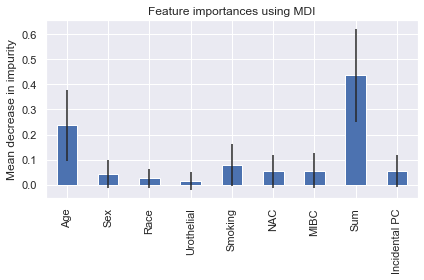

In [7]:
# Plot the importance of features
feature_names = X.columns
std = np.std([tree.feature_importances_ for tree in my_final_classifier.estimators_], axis=0)
importances = my_final_classifier.feature_importances_

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [8]:
# Save file with prediction
df.to_csv(testfile + '_prediction_IPC.txt', sep='\t')